# Project: Week 2

This week, I wanted to apply my knowledge of phylogenetic trees to COVID-19.  Specifically, I wanted to look at how the virus has spread between countries.  Even more specifically, I want to know: How did COVID-19 get to the US?

## Import Stuff

In [91]:
!pip install biopython

In [322]:
import pandas as pd
import numpy as np
import yaml
import urllib
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo
import matplotlib
import random
import matplotlib.pylab as plt
import matplotlib.patches as mpatches

In [117]:
%matplotlib inline

## Get Given Data - aligned sequences

First, I started with the data given by my professor.  Below is a table of all of the COVID-19 genomes made available by the galaxy project.  Specifically, this table contains the aligned sequences corresponding to the spike protein.

In [4]:
position_table = pd.read_csv('../../data/position_table.csv')

In [5]:
position_table

,seqid,S_1_1,S_1_2,S_1_3,S_2_1,S_2_2,S_2_3,S_3_1,S_3_2,S_3_3,...,S_1270_3,S_1271_1,S_1271_2,S_1271_3,S_1272_1,S_1272_2,S_1272_3,S_1273_1,S_1273_2,S_1273_3
0,MT007544.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
1,MT019529.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
2,MT019530.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
3,MT019531.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
4,MT019532.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,MT334544.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
673,MT334546.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
674,MT334547.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
675,MT334557.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A


## Get location and date data

Next, I wanted to get extra info about these genomes, like when and where the sample was taken.  
After rooting around on the galaxy project website, I found a script called _fetch_sra_acc.sh_.  In this file, I found out that they get their data from the NCBI.  Specifically, they pull info on the genomes from a file called [ncov-sequences.yaml](https://www.ncbi.nlm.nih.gov/core/assets/genbank/files/ncov-sequences.yaml).  I loaded the data into a dictionary to look up in.

In [16]:
with urllib.request.urlopen("https://www.ncbi.nlm.nih.gov/core/assets/genbank/files/ncov-sequences.yaml") as response:
    text = response.read()

In [18]:
lookup = yaml.load(text)

C:\Users\Alex\anaconda3\lib\site-packages\ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.


In [53]:
name_to_description = {}

for description in lookup["genbank-sequences"]:
    name = description["accession"]
    name_to_description[name] = description

## Combine Data

Next, I swept over my genome table to add the extra location and date info.

In [63]:
position_table["name"] = position_table["seqid"].str.replace("\.\d", "")

In [66]:
def get_country(name):
    if name in name_to_description:
        description = name_to_description[name]
        country = description["locality"]["country"]
        return country
    else:
        return np.nan

position_table["country"] = position_table["name"].apply(get_country)
position_table["country"].isna().sum()

9

Looks like there are only 9 genomes without a country.

In [69]:
def get_state(name):
    if name in name_to_description:
        description = name_to_description[name]
        if "state" in description["locality"]:
            state = description["locality"]["state"]
            return state
        else:
            return np.nan
    else:
        return np.nan

position_table["state"] = position_table["name"].apply(get_state)
position_table["state"].isna().sum()

178

There are 178 genomes without a state.

In [185]:
def get_date(name):
    if name in name_to_description:
        description = name_to_description[name]
        date = description["collection-date"]
        return date
    else:
        return np.nan

position_table["date"] = position_table["name"].apply(get_date)
position_table["date"].isna().sum()

9

There are 9 genomes without a date.  Below, I looked at the dates and decided to clean out a few.

In [187]:
position_table["date"].unique()

array([datetime.date(2020, 1, 25), datetime.date(2019, 12, 23),
       datetime.date(2019, 12, 30), datetime.date(2020, 1, 1),
       datetime.date(2020, 1, 29), datetime.date(2020, 1, 20),
       datetime.date(2020, 1, 31), '2020-01', datetime.date(2020, 1, 28),
       datetime.date(2020, 1, 27), datetime.date(2020, 1, 17),
       datetime.date(2020, 2, 5), datetime.date(2020, 1, 13),
       datetime.date(2020, 2, 7), datetime.date(2020, 1, 8),
       datetime.date(2020, 2, 6), datetime.date(2020, 2, 10),
       datetime.date(2020, 2, 11), datetime.date(2020, 2, 23),
       datetime.date(2020, 2, 28), datetime.date(2020, 1, 26),
       datetime.date(2020, 2, 24), datetime.date(2020, 2, 2),
       datetime.date(2020, 2, 17), datetime.date(2020, 2, 20),
       datetime.date(2020, 2, 25), datetime.date(2020, 2, 18),
       datetime.date(2020, 2, 21), datetime.date(2020, 1, 30),
       datetime.date(2020, 2, 27), datetime.date(2020, 2, 29),
       datetime.date(2020, 3, 1), datetime.date(

In [192]:
position_table = position_table[position_table["date"] != 2020]

In [193]:
position_table = position_table[~position_table["date"].isna()]

In [198]:
position_table["date"] = pd.to_datetime(position_table["date"])

Finally, I took a look at some of the country and state info.

In [78]:
position_table["country"].unique()

array(['Australia', 'China', 'USA', 'South Korea', 'Taiwan', 'Nepal',
       'Sweden', 'Brazil', 'India', 'Italy', 'Viet Nam', 'Spain',
       'Pakistan', 'Peru', 'Israel', nan, 'France', 'Iran',
       'South Africa', 'Turkey', 'Greece'], dtype=object)

In [75]:
position_table["state"].unique()

array(['Victoria', 'Hubei, Wuhan', 'WA', 'CA', 'Hangzhou', 'WI', 'MA',
       nan, 'IL', 'Yunnan', 'TX', 'Guangdong, Guangzhou', 'Guangzhou',
       'Beijing', 'Snohomish County, WA', 'Kerala State', 'Shanghai',
       'MN', 'CA, San Diego County', 'Ho Chi Minh city', 'Valencia',
       'Gilgit', 'CT', 'Zhejiang, Hangzhou', 'San Francisco, CA', 'KPK',
       'RI', 'GA', 'OR', 'FL', 'Anhui, Fuyang', 'Wuhan', 'North Carolina',
       'AZ', 'NH', 'NY', 'NC', 'VA', 'KwaZulu-Natal', 'DC', 'IA', 'IN',
       'KS', 'LA', 'MD', 'MO', 'NE', 'NJ', 'NV', 'OH', 'PA', 'SC', 'UT'],
      dtype=object)

## Problem

I wanted to take a look at how COVID-19 got to the US.  To do this, I first selected the first 10 recorded COVID-19 genomes in the US.

In [229]:
first_usa_infections = sorted(position_table[position_table["country"] == "USA"]["date"])[:10]
first_usa_infections

[Timestamp('2020-01-19 00:00:00'),
 Timestamp('2020-01-19 00:00:00'),
 Timestamp('2020-01-25 00:00:00'),
 Timestamp('2020-01-25 00:00:00'),
 Timestamp('2020-01-27 00:00:00'),
 Timestamp('2020-01-28 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-01-29 00:00:00')]

Then, I selected the latest date from among those.

In [231]:
max_first_usa_infections = max(first_usa_infections)

## Select our sequences for analysis

For my analysis, I selected all of the sequences that were recorded before the date I selected.

In [ ]:
position_table = position_table.set_index("seqid")

In [232]:
subset_seqs = position_table[position_table["date"] < max_first_usa_infections].index

In [233]:
subset_seqs

Index(['MT007544.1', 'MT019529.1', 'MT019530.1', 'MT019531.1', 'MT019532.1',
       'MT019533.1', 'MT020880.1', 'MT020881.1', 'MT039873.1', 'MT039890.1',
       'MT044257.1', 'MT044258.1', 'MT049951.1', 'MT072688.1', 'MT093631.2',
       'MT123292.2', 'MT135041.1', 'MT135042.1', 'MT135043.1', 'MT135044.1',
       'MT012098.1', 'MT192759.1', 'MT192772.1', 'MT192773.1', 'MT226610.1',
       'MT253696.1', 'MT253697.1', 'MT253698.1', 'MT253699.1', 'MT253700.1',
       'MT253701.1', 'MT253702.1', 'MT253703.1', 'MT253704.1', 'MT253705.1',
       'MT253706.1', 'MT253707.1', 'MT253708.1', 'MT253709.1', 'MT253710.1',
       'MT259226.1', 'MT259227.1', 'MT259228.1', 'MT259229.1', 'MT259230.1',
       'MT259231.1', 'MT233526.1', 'MT246667.1', 'MT291826.1', 'MT291827.1',
       'MT291828.1', 'MT291829.1', 'MT291830.1', 'MT291831.1', 'MT291832.1',
       'MT291833.1', 'MT291834.1', 'MT291835.1', 'MT039874.1'],
      dtype='object', name='seqid')

## Select our distance metric

Next, I got a distance matrix among all of the selected sequences.  I decided to stick with a simple distance metric - just the number of differences between the two.  This seemed appropriate because the sequences were relatively short and well-aligned.

In [234]:
def get_distance(seq1, seq2):
    return sum(seq1 != seq2)

In [321]:
distances = {}
for i,seqid1 in enumerate(subset_seqs):
    distances[seqid1,seqid1]=0
    for j in range(i+1,len(subset_seqs)):
        seqid2 = subset_seqs[j]
        distances[seqid1,seqid2] = get_distance(position_table.loc[seqid1], position_table.loc[seqid2])
        distances[seqid2,seqid1] = distances[seqid1,seqid2]
distances = pd.Series(distances).unstack()
distances.head()

,MT007544.1,MT012098.1,MT019529.1,MT019530.1,MT019531.1,MT019532.1,MT019533.1,MT020880.1,MT020881.1,MT039873.1,...,MT291826.1,MT291827.1,MT291828.1,MT291829.1,MT291830.1,MT291831.1,MT291832.1,MT291833.1,MT291834.1,MT291835.1
MT007544.1,0,10,6,6,6,6,6,5,5,6,...,6,6,7,6,6,6,5,6,6,6
MT012098.1,10,0,9,9,9,9,9,9,9,9,...,9,9,10,9,9,9,9,9,9,8
MT019529.1,6,9,0,2,2,2,2,5,5,3,...,3,3,4,3,3,3,3,3,3,3
MT019530.1,6,9,2,0,1,1,2,5,5,3,...,2,2,3,2,2,3,3,3,3,3
MT019531.1,6,9,2,1,0,1,2,5,5,3,...,2,2,3,2,2,3,3,3,3,3


## Select colors for each country

I knew that I would want to visualize my results, so I assigned a color to each of the countries in my subset of genomes.

In [428]:
countries = position_table.loc[subset_seqs]["country"].unique()
countries

array(['Australia', 'China', 'USA', 'South Korea', 'Nepal', 'India',
       'Taiwan', 'Viet Nam'], dtype=object)

In [429]:
country_to_color = {}

In [430]:
all_colors = [color for color in Phylo.BaseTree.BranchColor.color_names
              if len(color) > 1 and color not in ["white", "grey"]]
all_colors

['red',
 'yellow',
 'green',
 'cyan',
 'blue',
 'magenta',
 'black',
 'maroon',
 'olive',
 'lime',
 'aqua',
 'teal',
 'navy',
 'fuchsia',
 'purple',
 'silver',
 'gray',
 'pink',
 'salmon',
 'orange',
 'gold',
 'tan',
 'brown']

In [435]:
#colors = random.sample(all_colors, len(countries))

In [437]:
colors = all_colors[:len(countries)]

In [438]:
for country, color in zip(countries, colors):
    country_to_color[country] = color

In [439]:
country_to_color

{'Australia': 'red',
 'China': 'yellow',
 'USA': 'green',
 'South Korea': 'cyan',
 'Nepal': 'blue',
 'India': 'magenta',
 'Taiwan': 'black',
 'Viet Nam': 'maroon'}

I also made a legend for my graph at the end.

In [440]:
patches = []

for country in country_to_color:
    patch = mpatches.Patch(color=country_to_color[country], label=country)
    patches.append(patch)

## Use Biopython to construct a phylogenetic tree

Finally, I used Biopython to contruct a phylogenetic tree from my distance matrix

In [441]:
matrix = np.tril(distances.values).tolist()
for i in range(len(matrix)):
    matrix[i] = matrix[i][:i+1]
distance_matrix = DistanceMatrix(list(distances.index), matrix)

In [442]:
tree_constructor = DistanceTreeConstructor()

#### Neighbor Joining tree

I tried out a Neighbor Joining tree and an Upgma tree, and the Neighbor Joining tree worked better in the end.

In [443]:
nj_tree = tree_constructor.nj(distance_matrix)

In [444]:
nj_tree.ladderize()

In [445]:
for clade in nj_tree.get_terminals():
    country = get_country(clade.name.split(".")[0])
    clade.color = country_to_color[country]

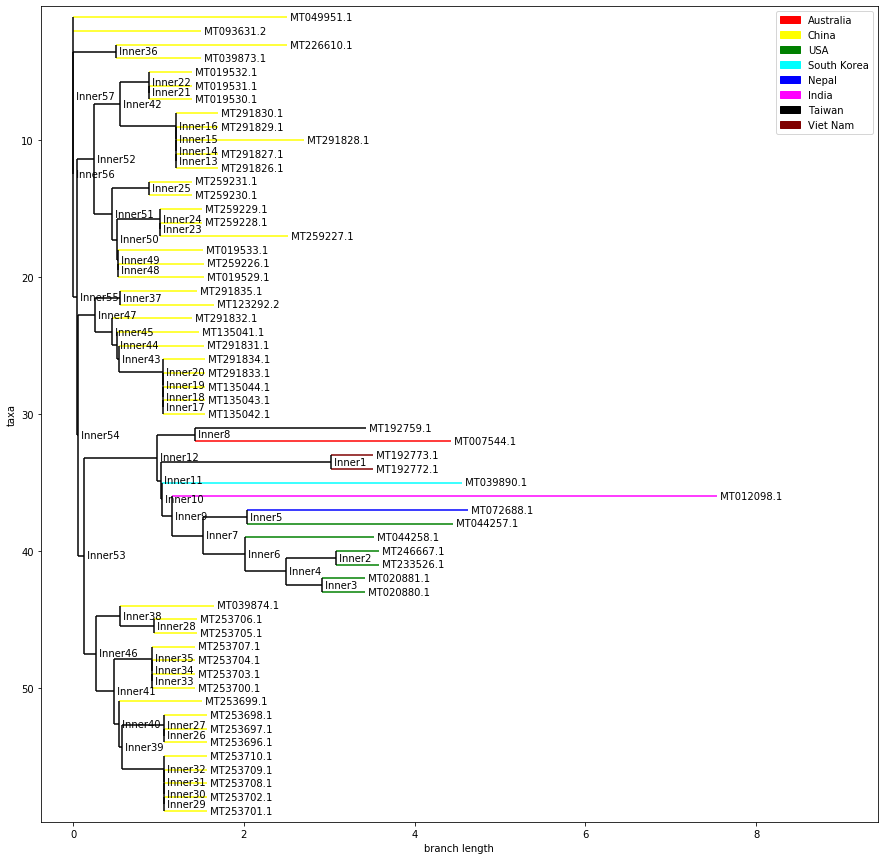

In [446]:
fig = plt.figure(figsize=(15, 15))
axes = fig.add_subplot(1, 1, 1)
plt.legend(handles=patches)
Phylo.draw(nj_tree, axes=axes)

My final tree indicates that the virus started in China (as most people agree).  One offshoot seemed to send the virus to the rest of the world - South Korea, India, Nepal, and the US.  The first known cases in the US are more closely related the the first case in Nepal.  Perhaps this could be used to better inform who first brought the virus here.